In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, kurtosis
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# Load the data
train_df = pd.read_csv('/Users/wuwenze/Library/CloudStorage/OneDrive-american.edu/study in SD/MGTF424/Final Project/mgtf-424-final-2024-2/train.csv')
test_df = pd.read_csv('/Users/wuwenze/Library/CloudStorage/OneDrive-american.edu/study in SD/MGTF424/Final Project/mgtf-424-final-2024-2/test.csv')

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# Convert 'timestamp' to datetime
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], errors='coerce')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], errors='coerce')

# Extract time features
def extract_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['day'] = df['timestamp'].dt.day
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5
    return df

train_df = extract_time_features(train_df)
test_df = extract_time_features(test_df)

# Ensure all required columns are present and are numeric
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Extract the magic indicators
magic_indicators = [col for col in train_df.columns if 'indicator' in col]

# Convert magic indicators to numeric
train_df = convert_to_numeric(train_df, magic_indicators)
test_df = convert_to_numeric(test_df, magic_indicators)

# Fill missing values with median for numeric columns only
imputer = SimpleImputer(strategy='median')
train_df[magic_indicators] = imputer.fit_transform(train_df[magic_indicators])
test_df[magic_indicators] = imputer.transform(test_df[magic_indicators])

# Function to apply rolling window
def add_rolling_features(df, columns, window_sizes):
    for window in window_sizes:
        for col in columns:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
            df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
            df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
    return df

# Apply rolling window features to the train and test datasets
window_sizes = [3, 5, 10]  # Define the window sizes you are interested in
train_df = add_rolling_features(train_df, magic_indicators, window_sizes)
test_df = add_rolling_features(test_df, magic_indicators, window_sizes)

# Display the head of the updated train_df to show new rolling features
print(train_df.head())

# Count the number of True and False 'roi' for each 'asset_id'
roi_counts = train_df.groupby('asset_id')['roi'].value_counts().unstack().fillna(0)
roi_counts.columns = ['False_count', 'True_count']
roi_counts['Total'] = roi_counts['False_count'] + roi_counts['True_count']

# Display the counts
print(roi_counts)

true_count_distribution = roi_counts['True_count'].describe()
roi_counts.sort_values(by='True_count',ascending=False)
roi_counts

# Filter based on 'roi'
def filter_roi(df):
    asset_counts = df.groupby('asset_id')['roi'].sum()
    filter_assets = asset_counts[asset_counts > 120].index
    df_filtered = df[df['asset_id'].isin(filter_assets) & df['roi']]
    df_remaining = df[~df['asset_id'].isin(filter_assets)]
    return pd.concat([df_filtered, df_remaining])

train_df = filter_roi(train_df)

# Aggregate features
def aggregate_features(df, is_train=True):
    agg_dict = {
        # Time features
        'hour': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'minute': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'second': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'day': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'dayofweek': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'month': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'quarter': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'is_weekend': 'mean',
        'indicator_1a': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_1b': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_1c': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_1d': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_1e': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_1f': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2a': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2b': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2c': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2d': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2e': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'indicator_2f': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'company_age': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'company_size': ['mean', 'std', 'min', 'max', 'median', 'var'],
        'revenue': ['mean', 'std', 'min', 'max', 'median', 'var']
    }

    for indicator in magic_indicators:
        agg_dict[indicator] = ['mean', 'std', 'min', 'max', 'median', 'var']
    
    if is_train:
        agg_dict['return_on_asset'] = 'mean'
    
    # Perform aggregation
    agg_df = df.groupby('asset_id').agg(agg_dict).reset_index()
        # Flatten MultiIndex columns
    agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns.values]
    return agg_df

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarnin

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarn

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/3677742258.py:54: PerformanceWarnin

      timestamp                              asset_id   roi  indicator_1a  \
63713       NaT  995bdd73-3292-4e19-802a-9db369b62ac3  True        1479.0   
63714       NaT  995bdd73-3292-4e19-802a-9db369b62ac3  True        1875.0   
63715       NaT  995bdd73-3292-4e19-802a-9db369b62ac3  True        1957.0   
63716       NaT  995bdd73-3292-4e19-802a-9db369b62ac3  True        1596.0   
63717       NaT  995bdd73-3292-4e19-802a-9db369b62ac3  True        1105.0   

       indicator_1b  indicator_1c  indicator_1d  indicator_1e  indicator_1f  \
63713         103.0         956.0        4514.0       -7999.0        8438.0   
63714         199.0        1516.0       -4616.0       -7602.0        1770.0   
63715        -288.0        1531.0       -1924.0       -4728.0        5458.0   
63716        -850.0        1623.0        1075.0       -5290.0        6099.0   
63717        -804.0        1443.0        4946.0       -7665.0        5634.0   

       return_on_asset  ...  indicator_2f_rolling_std_10_rolli

In [2]:
train_agg = aggregate_features(train_df, is_train=True)
test_agg = aggregate_features(test_df, is_train=False)

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:53: PerformanceWarning

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:53: PerformanceWarning: 

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_60388/225988996.py:52: PerformanceWarning

            timestamp                              asset_id    roi  \
0 2023-03-25 16:14:50  c786546e-1788-4dd3-ad7c-66db95294427  False   
1                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
2                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
3                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
4                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   

   indicator_1a  indicator_1b  indicator_1c  indicator_1d  indicator_1e  \
0         -18.0        -550.0        -149.0        1243.0       -7576.0   
1         -12.0        -551.0        -149.0        1243.0       -7576.0   
2          -5.0        -556.0        -157.0        1243.0       -7576.0   
3          -6.0        -550.0        -161.0        1399.0       -7575.0   
4         -17.0        -548.0        -154.0        1399.0       -7575.0   

   indicator_1f  return_on_asset  ...  indicator_2d_rolling_min_10  \
0       -2204.0               30  ...                     

In [5]:
train_agg

,asset_id_,hour_mean,hour_std,hour_min,hour_max,hour_median,hour_var,minute_mean,minute_std,minute_min,...,company_size_max,company_size_median,company_size_var,revenue_mean,revenue_std,revenue_min,revenue_max,revenue_median,revenue_var,return_on_asset_mean
0,00b82906-7836-428e-b7b1-0f8564989226,17.0,0.0,17.0,17.0,17.0,0.0,0.350000,0.489360,0.0,...,54,54.0,0.0,165.0,0.0,165,165,165.0,0.0,34.0
1,02c61b56-5241-44f9-bbef-24c112512804,18.0,0.0,18.0,18.0,18.0,0.0,18.000000,0.000000,18.0,...,55,55.0,0.0,167.0,0.0,167,167,167.0,0.0,32.0
2,034da9c2-b8a2-44c5-9c34-e7728b98a51b,18.0,0.0,18.0,18.0,18.0,0.0,25.000000,0.000000,25.0,...,58,58.0,0.0,170.0,0.0,170,170,170.0,0.0,37.0
3,061556d8-751f-46f0-b479-08ba731c7840,18.0,0.0,18.0,18.0,18.0,0.0,55.939394,0.242306,55.0,...,59,59.0,0.0,182.0,0.0,182,182,182.0,0.0,40.0
4,06c5017c-d3ec-48c2-8716-0e77e753c884,23.0,0.0,23.0,23.0,23.0,0.0,45.473684,0.512989,45.0,...,56,56.0,0.0,164.0,0.0,164,164,164.0,0.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,fdcfcede-893e-4f98-aadf-94a49a70ddae,17.0,0.0,17.0,17.0,17.0,0.0,56.000000,0.000000,56.0,...,57,57.0,0.0,180.0,0.0,180,180,180.0,0.0,27.0
234,fe41f443-daa2-4905-a179-56e6bc652f06,19.0,0.0,19.0,19.0,19.0,0.0,28.062500,0.250000,28.0,...,70,70.0,0.0,163.0,0.0,163,163,163.0,0.0,31.0
235,fe63e3b6-dd93-4d63-a3f7-d8f2e49dc318,17.0,0.0,17.0,17.0,17.0,0.0,44.000000,0.000000,44.0,...,62,62.0,0.0,184.0,0.0,184,184,184.0,0.0,38.0
236,ffbe4771-b188-4cda-9e94-96e8a0c45450,22.0,0.0,22.0,22.0,22.0,0.0,20.000000,0.000000,20.0,...,70,70.0,0.0,182.0,0.0,182,182,182.0,0.0,39.0


In [2]:
# Prepare features and target variable
X = train_agg.drop(columns=['return_on_asset_mean'])
y = train_agg['return_on_asset_mean']
test_X = test_agg.drop(columns=['asset_id_'])

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X.drop(columns=['asset_id_']))
test_X_poly = poly.transform(test_X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
test_scaled = scaler.transform(test_X_poly)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print the shapes to confirm
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_31624/2653464481.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_31624/2653464481.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
/var/folders/jt/kmz33btd2n703bvsz1482lww0000gn/T/ipykernel_31624/2653464481.py:53: PerformanceWarn

            timestamp                              asset_id    roi  \
0 2023-03-25 16:14:50  c786546e-1788-4dd3-ad7c-66db95294427  False   
1                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
2                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
3                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   
4                 NaT  c786546e-1788-4dd3-ad7c-66db95294427  False   

   indicator_1a  indicator_1b  indicator_1c  indicator_1d  indicator_1e  \
0         -18.0        -550.0        -149.0        1243.0       -7576.0   
1         -12.0        -551.0        -149.0        1243.0       -7576.0   
2          -5.0        -556.0        -157.0        1243.0       -7576.0   
3          -6.0        -550.0        -161.0        1399.0       -7575.0   
4         -17.0        -548.0        -154.0        1399.0       -7575.0   

   indicator_1f  return_on_asset  ...  indicator_2d_rolling_min_10  \
0       -2204.0               30  ...                     

In [3]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(190, 8911) (48, 8911) (190,) (48,)


In [12]:
# Extensive hyperparameter grid for XGBoost
param_grid_xgboost = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3], 
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [0.1, 1, 10]  # L2 regularization term on weights
}

In [13]:
# Model training and evaluation function with k-fold cross-validation
def train_and_evaluate_xgboost(model, param_grid):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,  # Number of parameter settings that are sampled
        cv=kf,  # K-Fold cross-validation
        scoring='neg_mean_absolute_error',  # Scoring method
        n_jobs=-1,  # Use all available cores
        verbose=1,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Validate the best model on the validation set
    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    return best_model, best_params, best_score, val_mae

In [15]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
# Train and evaluate XGBoost
xgboost_model = xgb.XGBRegressor(random_state=42)
best_xgboost_model, best_params_xgboost, best_score_xgboost, val_mae_xgboost = train_and_evaluate_xgboost(xgboost_model, param_grid_xgboost)

# Print the results
print("XGBoost Best Params:", best_params_xgboost)
print("XGBoost Best Cross-Validation Score (MAE):", -best_score_xgboost)
print("XGBoost Validation MAE:", val_mae_xgboost)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/wuwenze/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost Best Params: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
XGBoost Best Cross-Validation Score (MAE): 4.5316770754362405
XGBoost Validation MAE: 4.66206423441569


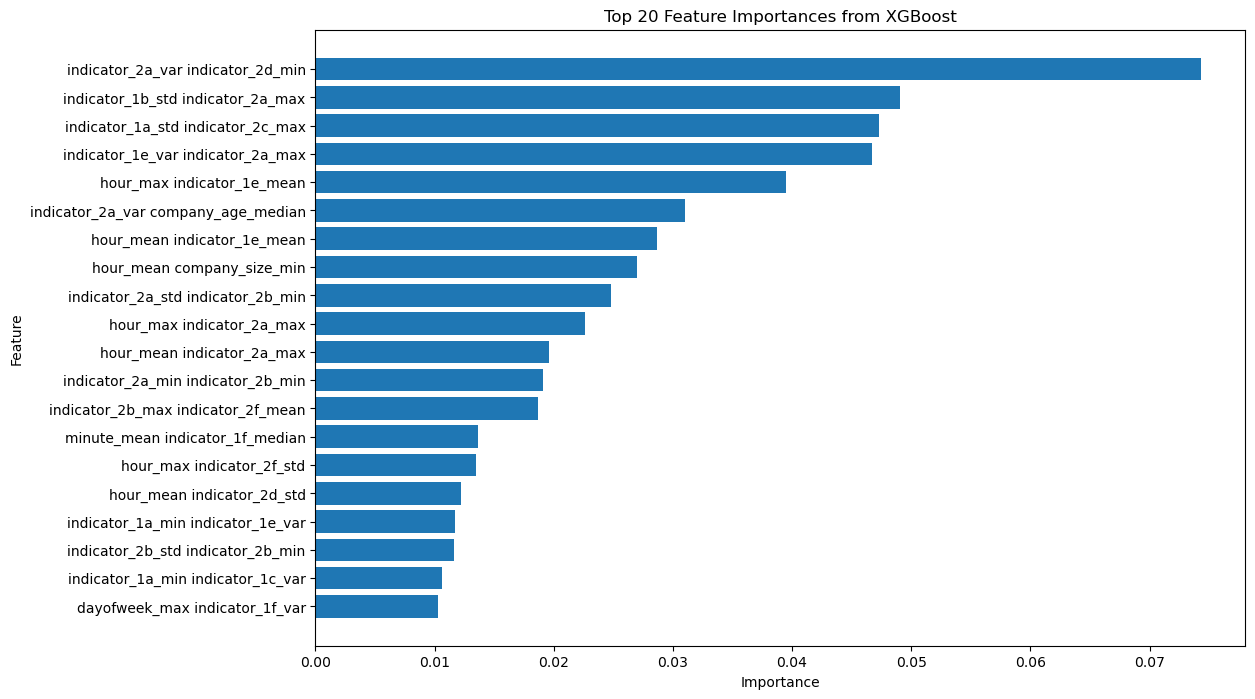

In [16]:

# Feature Importance Analysis
import matplotlib.pyplot as plt

# Get feature importance scores
feature_importances = best_xgboost_model.feature_importances_
features = poly.get_feature_names_out(X.drop(columns=['asset_id_']).columns)

# Create a DataFrame to hold feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance scores
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 important features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances from XGBoost")
plt.show()

In [17]:
best_params_xgboost, best_score_xgboost, val_mae_xgboost 

({'subsample': 0.8,
  'reg_lambda': 10,
  'reg_alpha': 0,
  'n_estimators': 400,
  'min_child_weight': 3,
  'max_depth': 3,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 0.6},
 -4.5316770754362405,
 4.66206423441569)

In [18]:
test_predictions = best_xgboost_model.predict(test_scaled)


submission = pd.DataFrame({
    'asset_id': test_agg['asset_id_'],
    'prediction': test_predictions
})

submission.to_csv('submission.csv', index=False)